# Seer Technical Interview: EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure (ictal) vs non seizure (interictal/healthy) EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (comprised of interictal and healthy). The goal is to demonstrate a deep learning approach for seizure detection from single-channel EEG data.


### Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  These segments were manually selected from continuous EEG recordings, artifact free and stationary. Specifically, sets C/D/E are used, with the goal of classifying ictal from interictal EEG segments. 

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |


### Challenges and limitations of BONN dataset
**Small dataset**: Relatively small dataset, using only 300 segments, 200 which are non-seizure and 100 which are seizure. 
- Key consideration in model architecture: dropout, weight decay, batch normalisation, number of layers
- Data augmentation (seizure segments)

**Class imbalance**: Class imbalance with 2:1 non-seizure to seizure ratio.
- Class weights
- Data augmentation of seizure segments


**No patient-level data**: Patients may belong in both training and testing samples, could cause overfitting and over-optimistic performance metrics
- Limitation: only way to test would be to do external validation from new dataset (not included in project) 


### Goals

1. Load and preprocess EEG segments from all sets
2. Normalize and filter EEG signals
3. Build and train a MLP to classify seizure vs non-seizure segments as a baseline comparison model
4. Build and train a **1D CNN** to classify seizure vs non-seizure segments
5. Evaluate model performance using loss curves, accuracy and confusion matrix
6. Apply data augmentation to address potential overfitting and limited sample size


### Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


In [1]:
# Third-party imports
import os
import sys
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    balanced_accuracy_score
)
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

# Project imports
# Add parent directory to path
sys.path.append(os.path.abspath('..'))
import scripts

# Custom functions and modules
from scripts.preprocess import normalise_segments, load_and_preprocess
from scripts.utils import plot_eeg_segment, plot_training_history
from scripts.train import train, evaluate
from scripts.CV import train_with_kfold_cv
from scripts.augmentation import visualize_augmentation_comparison, train_with_kfold_cv_augmented
from scripts.CNN_evaluation import (
    calculate_metrics_from_saved_models,
    print_quick_summary,
    plot_metrics_comparison,
    plot_kfold_results
)



## Load and Preprocess Data

**Filtering:** Butterworth filter to remove high frequency noise above 40 Hz
- Attenuates frquencies beyond cutoff of 40 Hz (e.g. may be caused by muscle artifacts, powerline noise), preserving key EEG rhythms without ripples


In [2]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    #"A": 0,
    #"B": 0,
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)
X = np.array(X) 
print("EEG segments shape:", X.shape)
y = np.array(y)
print("Labels shape:", y.shape)

EEG segments shape: (300, 4097)
Labels shape: (300,)


## Visualise EEG segments

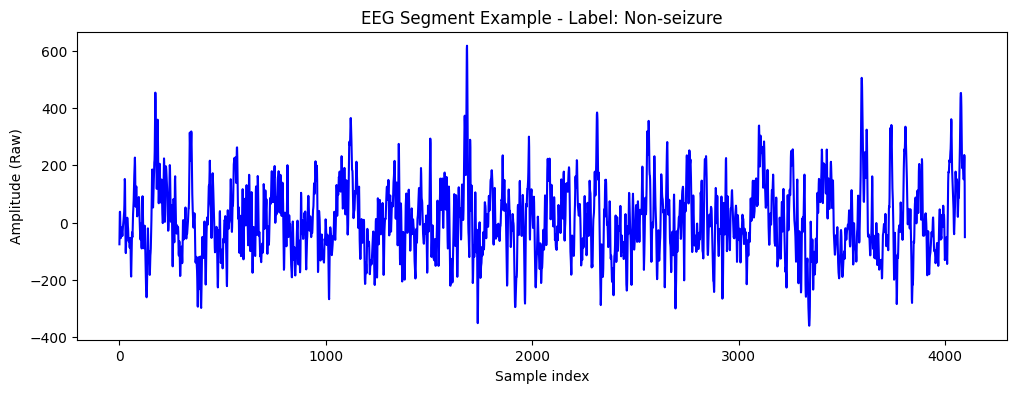

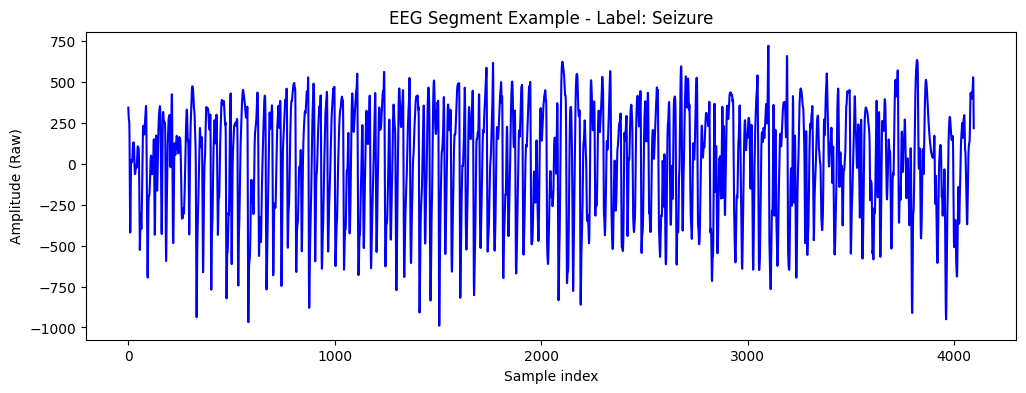

In [3]:
# Visualise example of non-seizure 
segment = X[0]  
label = y[0]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)


# Visualise example of seizure 
segment = X[-1] 
label = y[-1]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)

## Simple Multi-Layer Perceptron: Baseline Model
**Overview:**
The Multi-Layer Perceptron (MLP) is a fully connected neural network where each input feature is connected to every neuron in the next layer. For EEG classification, the MLP treats the signal as a flat vector of values, without explicitly considering the order or temporal relationships of the data points.

### Pros:
- Simple architecture: easy to implement and train
- Baseline performance: provides reference point to compare more complex CNN models
- Fewer hyperparameters

### Cons:
- Ignores temporal structures: doesn't consider the local patterns of EEG
- Overfitting risk: fully connected layers can have many parameters relative to number of samples

### Motivation:
By first training an MLP model, we can measure how much improvement is gained by 1D CNN models, which can detect temporal patterns and allows us to test pre-processing, training and evaluation pipelines on a simpler model before advancing to more complex models. 


In [12]:
# X: shape (300, 4097), y: labels (0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Normalise data
X_train_normalised, X_test_normalised = normalise_segments(X_train, X_test)

Train shape: (210, 4097)
Test shape: (90, 4097)


In [13]:
# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # (n_samples, 4097)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train tensor shape: {X_train_torch.shape}") 
print(f"Test tensor shape: {X_test_torch.shape}") 

Train tensor shape: torch.Size([210, 1, 4097])
Test tensor shape: torch.Size([90, 1, 4097])


In [14]:
class simple_EEG_MLP(nn.Module):
    def __init__(self, input_length=4097):
        super(simple_EEG_MLP, self).__init__()

        self.fc1 = nn.Linear(input_length, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x


mps
Epoch 1/25 | Train Loss: 0.7076, Train Acc: 0.3000 | Val Loss: 0.6127, Val Acc: 0.3333
Epoch 2/25 | Train Loss: 0.6229, Train Acc: 0.4429 | Val Loss: 0.6076, Val Acc: 0.3333
Epoch 3/25 | Train Loss: 0.5481, Train Acc: 0.6905 | Val Loss: 0.5853, Val Acc: 0.3444
Epoch 4/25 | Train Loss: 0.5091, Train Acc: 0.6810 | Val Loss: 0.5631, Val Acc: 0.9333
Epoch 5/25 | Train Loss: 0.4648, Train Acc: 0.7952 | Val Loss: 0.5466, Val Acc: 0.9222
Epoch 6/25 | Train Loss: 0.4465, Train Acc: 0.8857 | Val Loss: 0.5324, Val Acc: 0.8778
Epoch 7/25 | Train Loss: 0.3752, Train Acc: 0.9333 | Val Loss: 0.5152, Val Acc: 0.8556
Epoch 8/25 | Train Loss: 0.3822, Train Acc: 0.9476 | Val Loss: 0.5239, Val Acc: 0.8444
Epoch 9/25 | Train Loss: 0.3324, Train Acc: 0.9381 | Val Loss: 0.5245, Val Acc: 0.8444
Epoch 10/25 | Train Loss: 0.2880, Train Acc: 0.9619 | Val Loss: 0.5225, Val Acc: 0.8222
Epoch 11/25 | Train Loss: 0.2664, Train Acc: 0.9714 | Val Loss: 0.5107, Val Acc: 0.8444
Epoch 12/25 | Train Loss: 0.2520, Tra

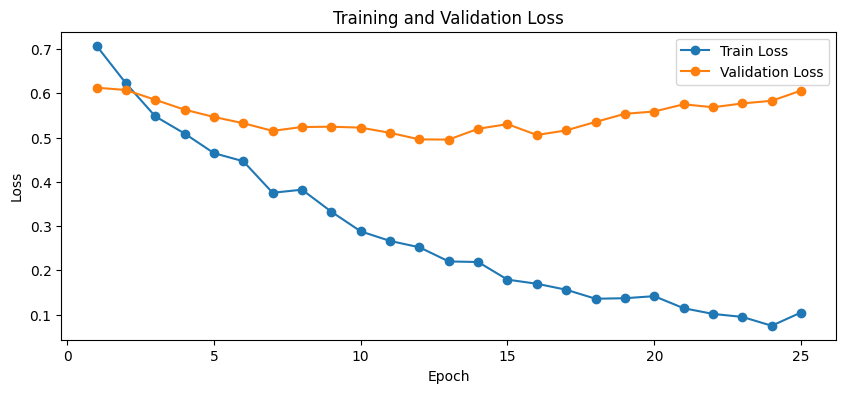

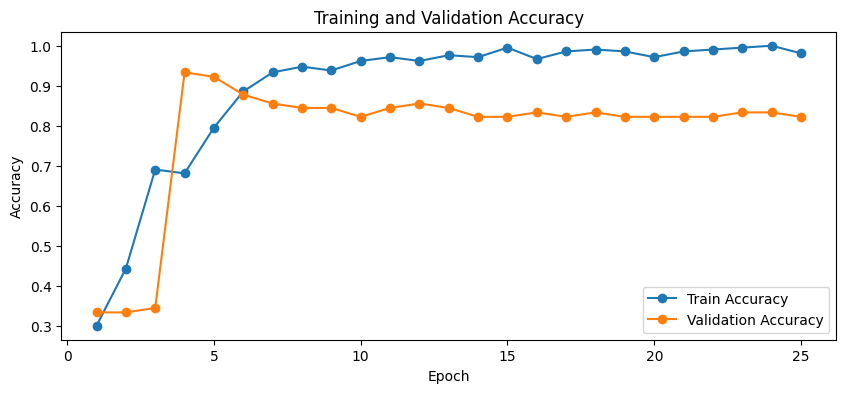

In [15]:
# Since this code is running on an M series chip (arm64), use MPS. In a cloud environment use CUDA.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = simple_EEG_MLP().to(device)
class_weights = torch.tensor([0.5, 1.0], dtype=torch.float)  # seizures get double weight
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # define optimisation algorithm

epochs = 25 # train the model for 25 full passes

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# train and evaluate each epoch
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, epochs=None)

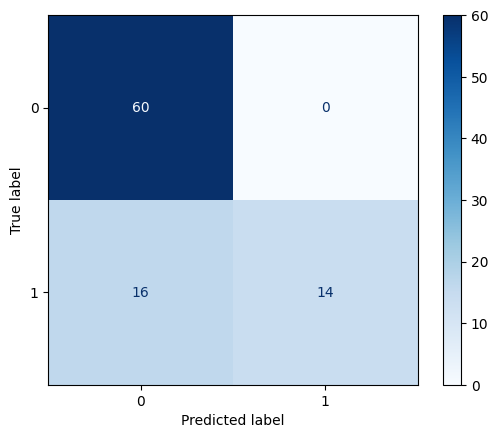

In [16]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # disable gradient computation (save memory and prevents updating model)
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)              # raw logits
        preds = torch.argmax(outputs, dim=1)  # predicted class
        all_preds.append(preds.cpu()) # move to cpu for sklearn/numpy
        all_labels.append(labels.cpu())

# concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')


### Simple MLP Model Summary 
The simple MLP model served as a baseline model for EEG classification, treating each segment as a flattened vector thus ignoring temporal structure of EEG. Training over 25 epochs, we can see that the MLP model quickly dropped loss and increased accuracy in training set, but showed signs of overfitting, with valdiation loss and accuracy being significantly worse. Based on the confusion matrix we can see that it is struggling with false negative (T2 error), which indicates that clinically, this would not be a good seizure detection model. 

This model serves as a useful reference, with subsequent CNN models focused on learning temporal structures of EEG. 


##  1D Convolutional Neural Network

### Overview
The 1D CNN applies convolutional filters along the temporal dimension of EEG signals.  
For EEG classification, it treats input as a **sequence of time samples**, allowing the model to learn local temporal patterns.

### Key components:
- **Convolutional layers:** Extract hierarchical features from raw signals  
- **Pooling layers:** Reduce temporal resolution while preserving key features  
- **Batch normalization:** Stabilizes training  
- **Dropout:** Prevents overfitting  
- **Fully connected layers:** Perform final binary classification  

### Pros
- Automatically learns temporal patterns without manual feature engineering 
- Far fewer parameters than a fully connected MLP, reduces risk of overfitting on small datasets
- Faster and computationally efficient compared to recurrent networks (e.g. LSTMs)  
- Well suited for time series classification  

### Cons
- Multiple hyperparameters to tune (filter sizes, channels, pooling strategies)  
- Requires sufficient training data to learn robust features  

### Motivation
1D CNNs capture temporal dynamics and patterns characteristic of seizure events while being computationally efficient for real-time applications.


### First trained a basic model: no data augmentation or hyperparameter tuning:

**Training Strategy:**
- Validation method: 5-fold cross-validation
- Normalization: Z-score normalization per fold (using training statistics only)
- Loss function: CrossEntropyLoss with class weights to handle class imbalance
- Optimizer: Adam with learning rate 1e-3 and weight decay 1e-4 (L2 regularisation)
- Pooling:
    - Local max pooling: reduces temporal dimension, adds local translational invariance, and reduces FC parameters
    - Global average pooling: condense each channel into single value before FC layers
- Fully connected layers: small FC head with dropout → reduces overfitting
- Regularization / overfitting control:
    -  Dropout in conv and FC layers
    - Early stopping with patience=5

In [17]:
## 1D CNN Model

class simple_EEG_CNN(nn.Module):
    def __init__(self, input_length=4097, dropout= 0.5):
        super(simple_EEG_CNN, self).__init__()

        #Input shape: (32, 1, 4097) 

        # Conv1: Capture seizure spike patterns (~150ms)
        # Kernel=25 → ~145ms at 173Hz
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=25, stride=1, padding=12) 
        self.bn1 = nn.BatchNorm1d(16) # BatchNorm after conv1
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout1 = nn.Dropout(dropout * 0.6)
        # After conv1+pool1: (32, 16, 1024)

        # Conv2: Capture medium-term patterns (~350ms)
        # Kernel=15 → ~350ms in the pooled space
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, stride=1, padding=7)
        self.bn2 = nn.BatchNorm1d(32) # BatchNorm after conv2
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout2 = nn.Dropout(dropout * 0.8)  
        # After conv3+pool3: (32, 32, 256)

        # Conv3: Capture long-term evolution patterns (~650 ms)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(64) # BatchNorm after conv3
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        # after conv 3 (32, 64, 64)
        
        # Dropout for regularization
        self.dropout3 = nn.Dropout(dropout)

        # global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(64, 64)  
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)  
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)  
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)  
        
        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x


In [18]:
# Since this code is running on an M series chip (arm64), use MPS. In a cloud environment use CUDA.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
fold_results = train_with_kfold_cv(
    X, 
    y, 
    simple_EEG_CNN,
    n_splits=5, 
    max_epochs=25, 
    batch_size=32, 
    device=device,
    patience= 5,
    min_delta= 0.001,
    model_kwargs={'input_length': 4097}
)

Starting 5-Fold Cross-Validation

FOLD 1/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0758/0.9625 | Val: 0.1882/0.9500 | Patience: 0/5
  Epoch 20/25 | Train: 0.0646/0.9750 | Val: 0.3388/0.8333 | Patience: 3/5
  Early stopping at epoch 22
  Fold 1 Summary:
    Best Val Acc: 0.9333 at epoch 17
    Total epochs: 22

FOLD 2/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1120/0.9667 | Val: 0.0877/0.9833 | Patience: 0/5
  Early stopping at epoch 15
  Fold 2 Summary:
    Best Val Acc: 0.9833 at epoch 10
    Total epochs: 15

FOLD 3/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0856/0.9750 | Val: 0.1510/0.9500 | Patience: 0/5
  Epoch 20/25 | Train: 0.1411/0.9583 | Val: 0.0990/0.9667 | Patience: 1/5
  Fold 3 Summary:
    Best Val Acc: 0.9833 at epoch 23
    Total epochs: 25

FOLD 4/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.16

### Evaluating Results

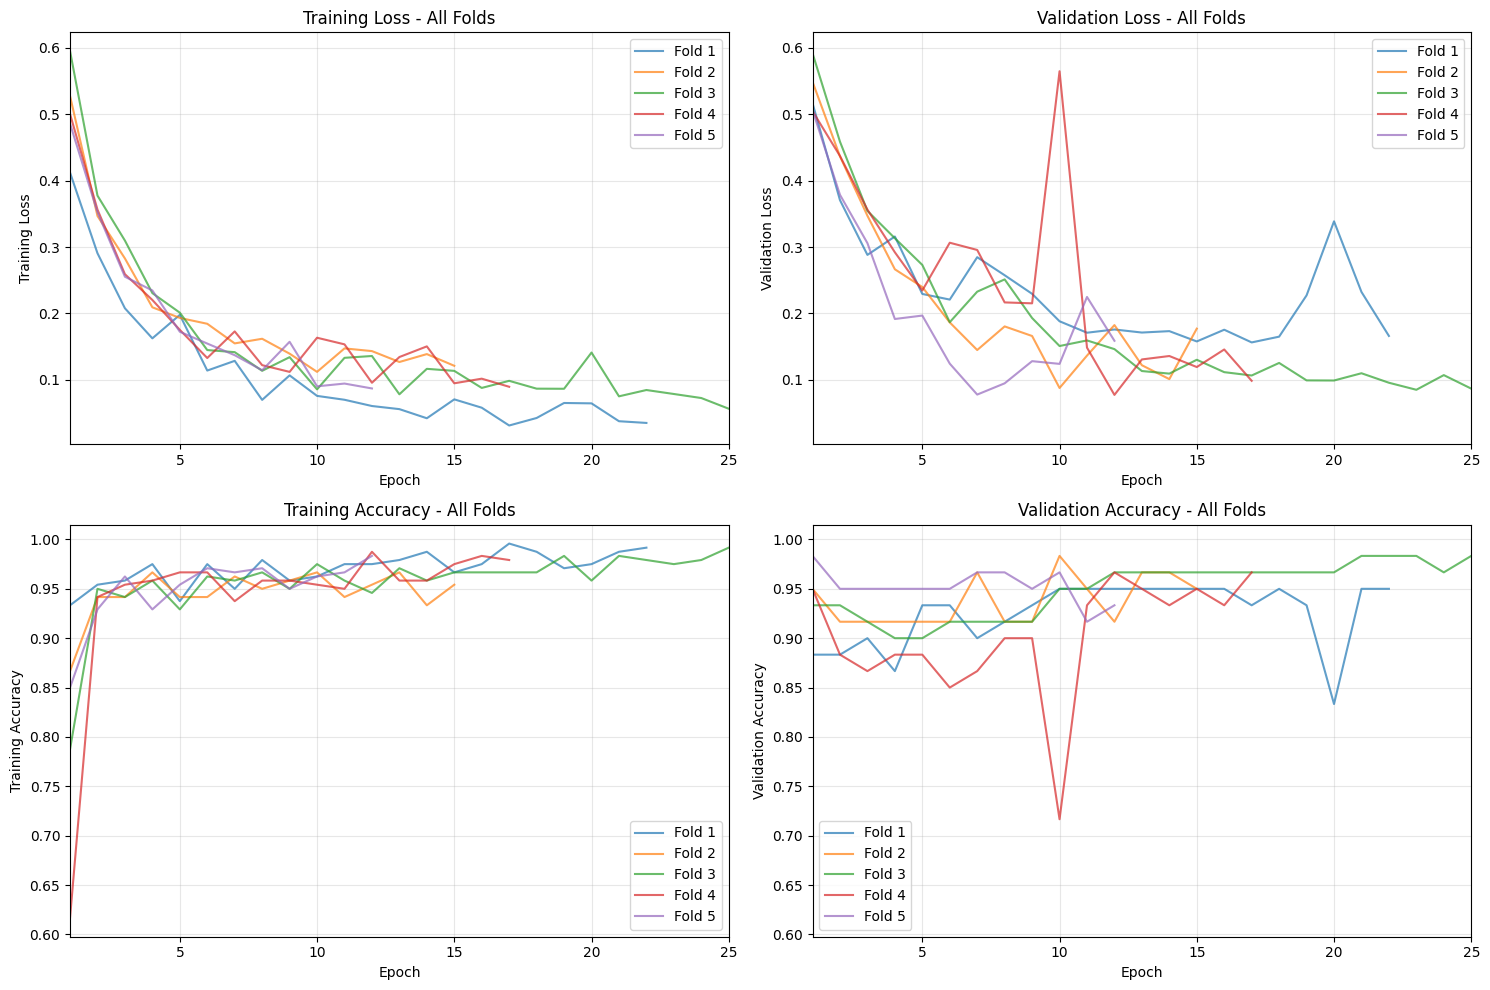

Mean accuracy: 0.9667
Std accuracy: 0.0183
Best fold: 2
Best accuracy: 0.9833


In [19]:
plot_kfold_results(fold_results, 5)

print(f"Mean accuracy: {np.mean(fold_results['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(fold_results['best_val_accs']):.4f}")


best_fold_idx = np.argmax(fold_results['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {fold_results['best_val_accs'][best_fold_idx]:.4f}")

Calculating metrics from saved models...

Fold 1: Acc=0.9333 | Bal_Acc=0.9282 | F1=0.9091 | Prec=0.9091 | Rec=0.9091
Fold 2: Acc=0.9833 | Bal_Acc=0.9667 | F1=0.9655 | Prec=1.0000 | Rec=0.9333
Fold 3: Acc=0.9833 | Bal_Acc=0.9722 | F1=0.9714 | Prec=1.0000 | Rec=0.9444
Fold 4: Acc=0.9667 | Bal_Acc=0.9630 | F1=0.9615 | Prec=1.0000 | Rec=0.9259
Fold 5: Acc=0.9667 | Bal_Acc=0.9444 | F1=0.9412 | Prec=1.0000 | Rec=0.8889

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9667 ± 0.0183     [0.9333, 0.9833]
Balanced Accuracy    0.9549 ± 0.0163     [0.9282, 0.9722]
F1 Score             0.9498 ± 0.0227     [0.9091, 0.9714]
Precision            0.9818 ± 0.0364     [0.9091, 1.0000]
Recall (Sensitivity) 0.9203 ± 0.0195     [0.8889, 0.9444]

Average Confusion Matrix:
  TN (Non-Seizure correct): 39.6
  FP (False alarm):         0.4
  FN (Missed seizure):      1.6 
  TP (Seizure caught):

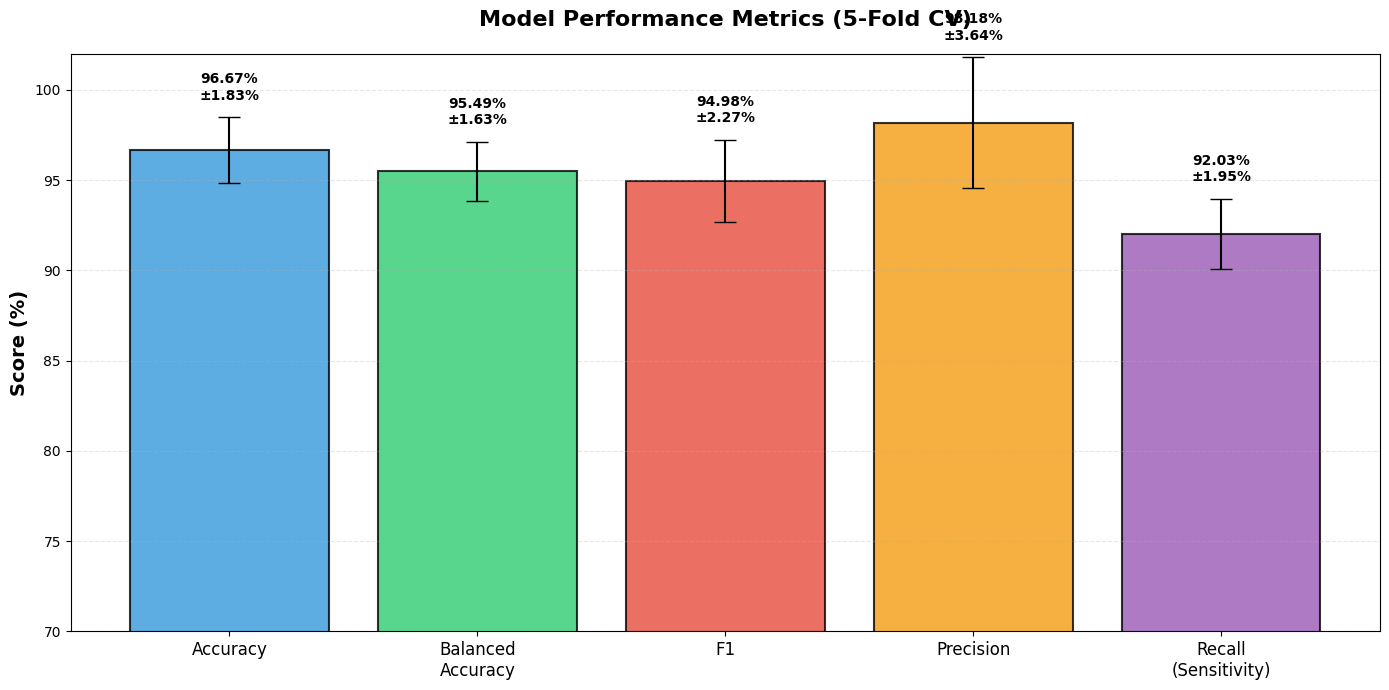

In [20]:
# Calculate comprehensive metrics
importlib.reload(scripts.CNN_evaluation)
from scripts.CNN_evaluation import calculate_metrics_from_saved_models
metrics = calculate_metrics_from_saved_models(X, y, simple_EEG_CNN, n_splits=5, device= device)
print_quick_summary(metrics)
plot_metrics_comparison(metrics)

### First 1D CNN Model Summary

- Overall, see pretty good accuracy, but the model clearly struggles with false negatives indicated by low recall
- Seeing variability in validation loss and accuracy compared to training: may be indicative of overfitting 
- Next steps: add data-augmentation, improve generalisability of model

## Second 1D CNN Model: Data Augmentation and Hyperparameter tuning

- What is data augmentation?
- Why is it useful?
- How will I implement

In [21]:
def augment_eeg_signal(signal, aug_type):
    """
    Augment a single EEG signal 
    """
    if aug_type == 'noise':
        noise_level = 0.05 * np.std(signal)
        noise = np.random.normal(0, noise_level, signal.shape)
        return signal + noise
    
    elif aug_type == 'scale':
        scale_factor = np.random.uniform(0.85, 1.15)
        return signal * scale_factor
    
    elif aug_type == 'shift':
        shift = np.random.randint(-100, 100)
        return np.roll(signal, shift)
    
    elif aug_type == 'warp':
        warp_factor = np.random.uniform(*(0.98, 1.02))
        orig_indices = np.arange(len(signal))
        new_indices = np.linspace(0, len(signal)-1, int(len(signal) * warp_factor))
        f = interp1d(new_indices, signal, kind='linear', fill_value='extrapolate')
        return f(orig_indices)
    
    else:
        return signal

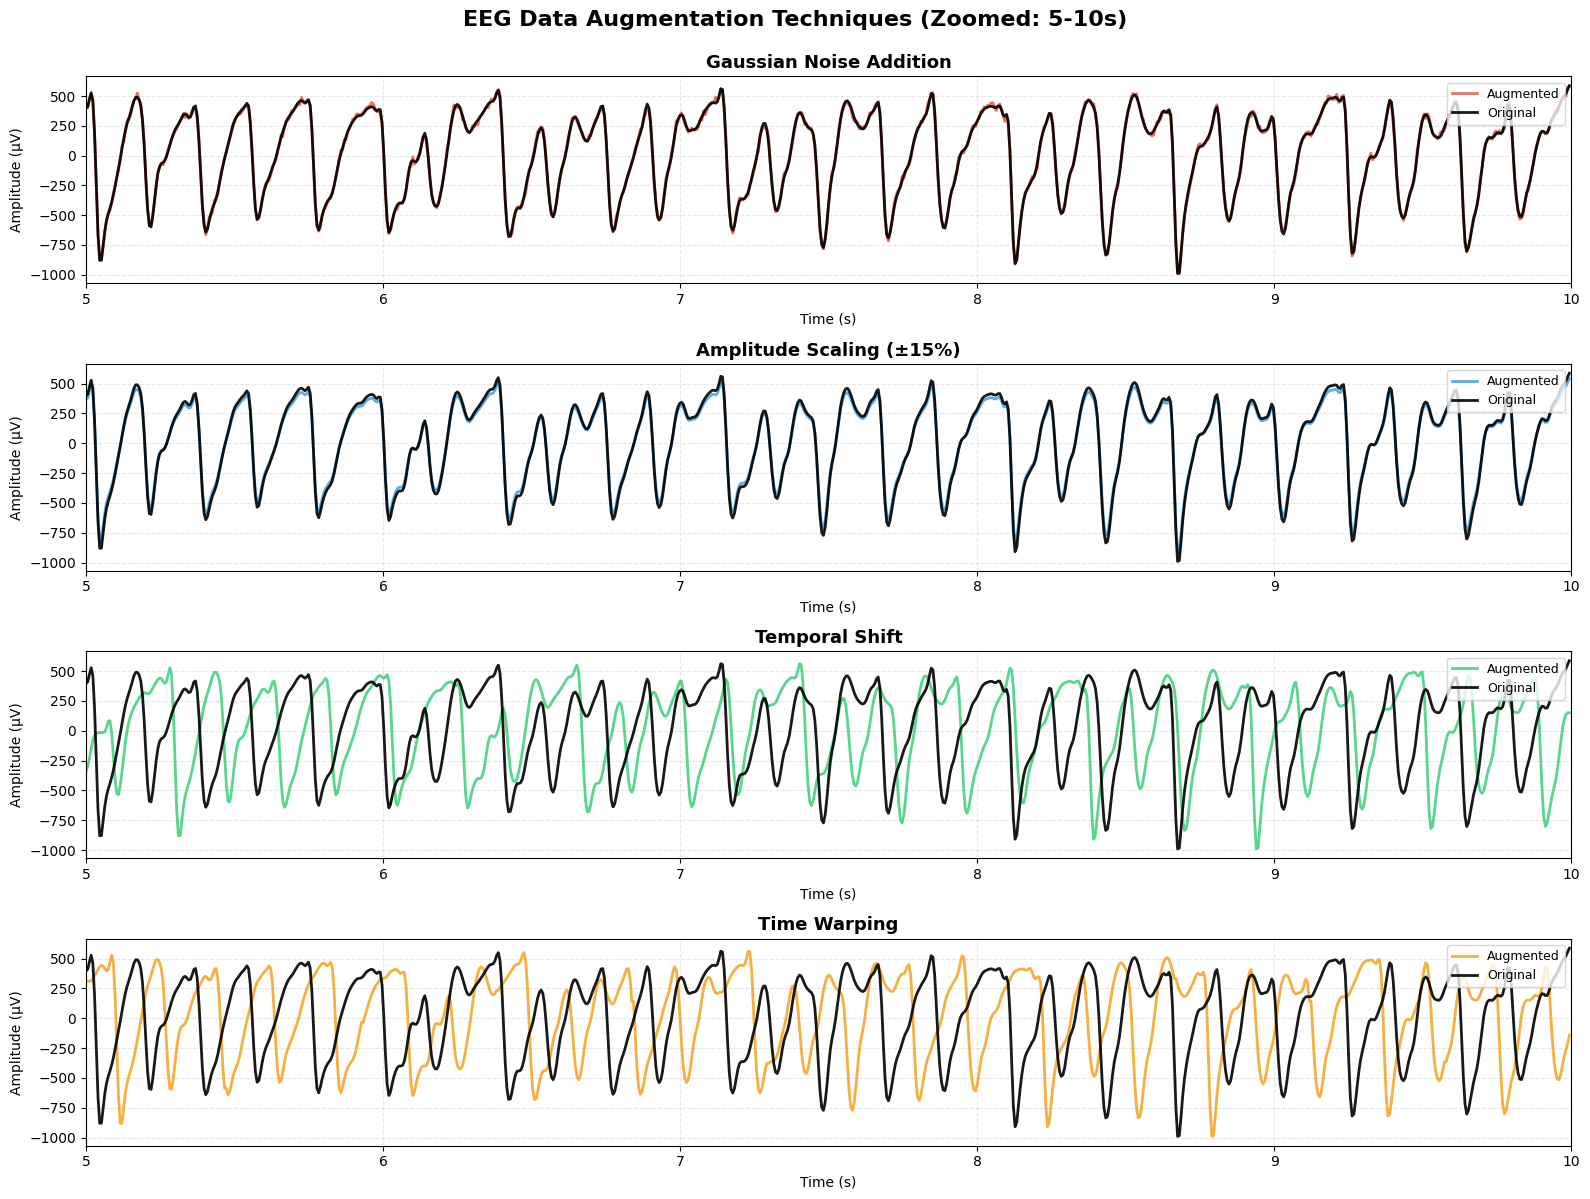

In [20]:
visualize_augmentation_comparison(X, sample_idx=-1)

In [22]:
cv_results_with_aug = train_with_kfold_cv_augmented(
    X, y,
    model_class=simple_EEG_CNN,
    n_splits=5,
    max_epochs=50,
    batch_size=32,
    device=device,
    use_augmentation=True,  # Use augmentation
    aug_methods=['noise', 'scale', 'shift', 'warp'],
    tune_hyperparams= True, n_tuning_trials = 3
)


Starting 5-Fold Cross-Validation
Using NESTED CV with hyperparameter tuning (3 trials/fold)
Using augmentation: ['noise', 'scale', 'shift', 'warp']

FOLD 1/5
------------------------------------------------------------
  Tuning hyperparameters (3 random trials)...
    Trial 1/3: LR=1e-03, BS=16, Dropout=0.40, WD=1e-04 → Val Acc: 0.9792
    Trial 2/3: LR=1e-04, BS=32, Dropout=0.50, WD=1e-05 → Val Acc: 0.9167
    Trial 3/3: LR=1e-03, BS=16, Dropout=0.50, WD=1e-04 → Val Acc: 0.9583
  → Best params: LR=1e-03, BS=16, Dropout=0.40, WD=1e-04 (Tuning Val Acc: 0.9792)
  Before augmentation: 78 seizures, 162 non-seizures
Original seizure samples: 78
Generating 72 augmented samples...
Final augmented seizure count: 150
  After augmentation: 150 seizures, 162 non-seizures
  Epoch 10/50 | Train: 0.0584/0.9840 | Val: 0.1719/0.9500 | Patience: 3/5
  Epoch 20/50 | Train: 0.0747/0.9712 | Val: 0.1621/0.9667 | Patience: 3/5
  Early stopping at epoch 22
  Fold 1 Summary:
    Best Val Acc: 0.9500 at epoch 

Calculating metrics from saved models...

Fold 1: Acc=0.9333 | Bal_Acc=0.9282 | F1=0.9091 | Prec=0.9091 | Rec=0.9091
Fold 2: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000
Fold 3: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000
Fold 4: Acc=0.9667 | Bal_Acc=0.9697 | F1=0.9643 | Prec=0.9310 | Rec=1.0000
Fold 5: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9800 ± 0.0267     [0.9333, 1.0000]
Balanced Accuracy    0.9796 ± 0.0282     [0.9282, 1.0000]
F1 Score             0.9747 ± 0.0356     [0.9091, 1.0000]
Precision            0.9680 ± 0.0398     [0.9091, 1.0000]
Recall (Sensitivity) 0.9818 ± 0.0364     [0.9091, 1.0000]

Average Confusion Matrix:
  TN (Non-Seizure correct): 39.2
  FP (False alarm):         0.8
  FN (Missed seizure):      0.4 
  TP (Seizure caught):

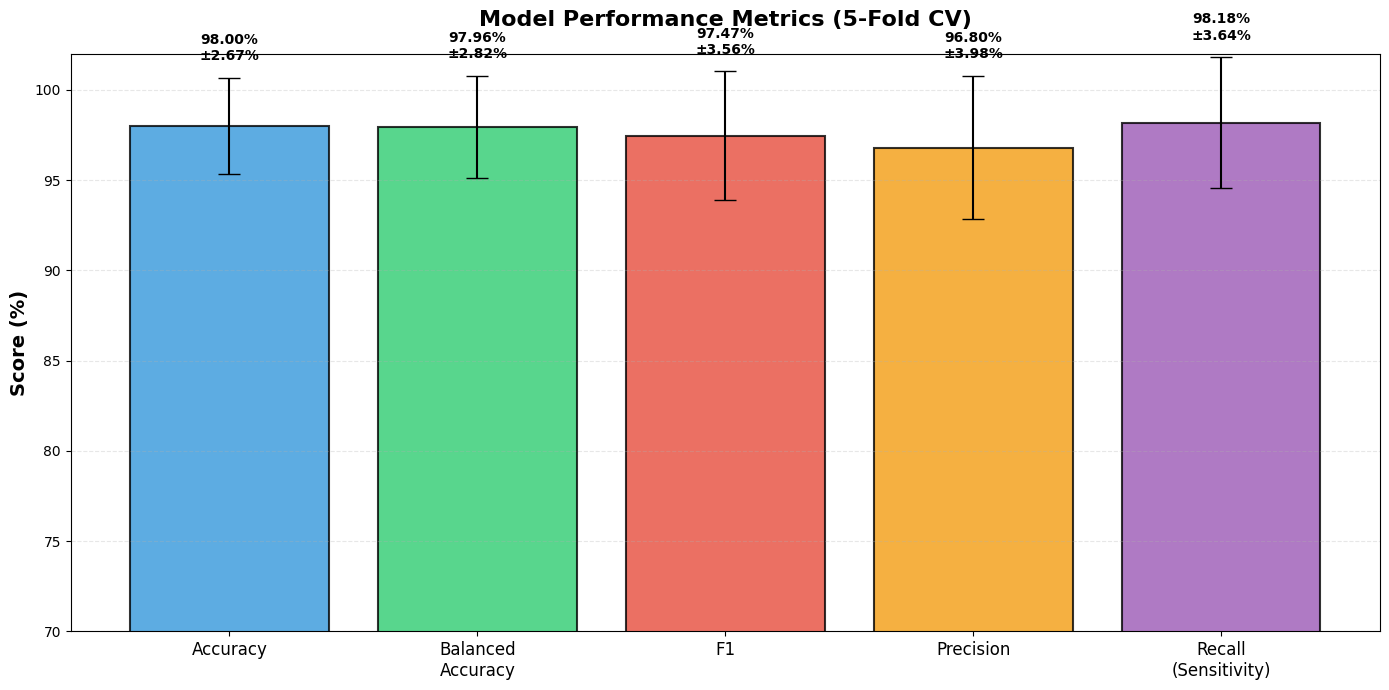

Comparison to non-augmented dataset metrics


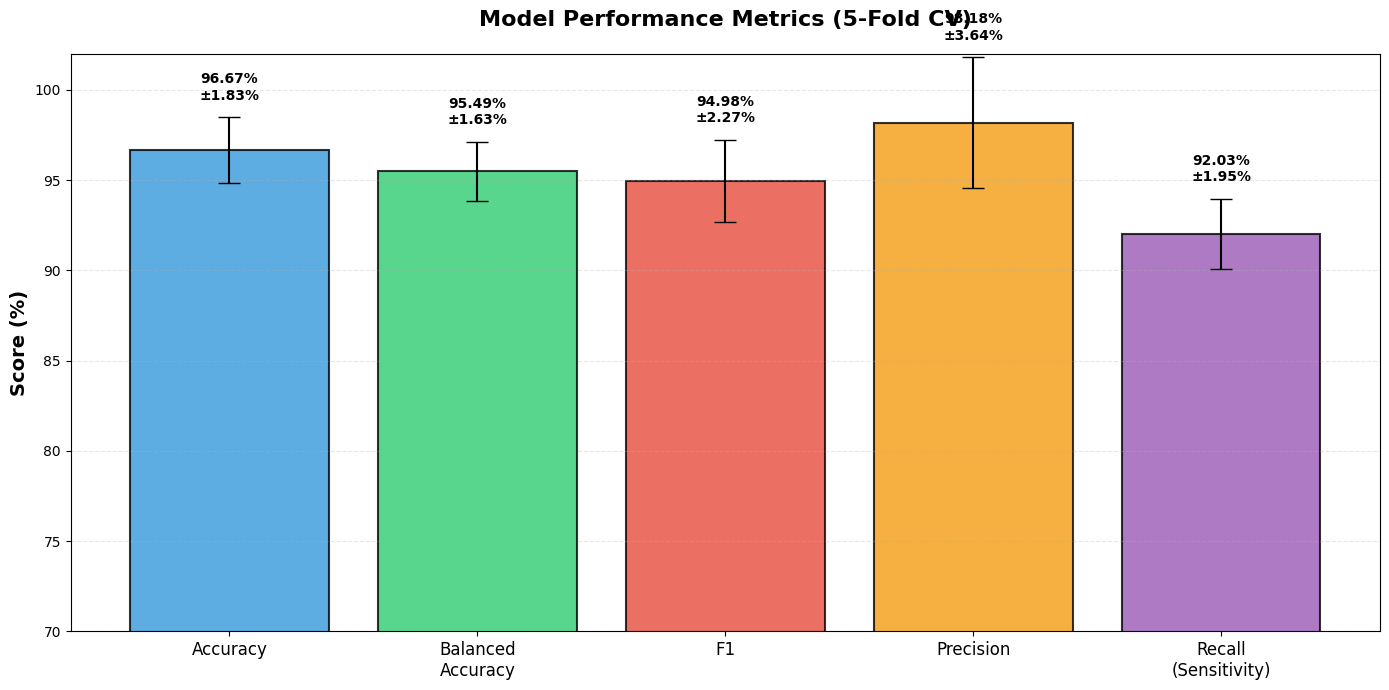

In [23]:
# Calculate metrics
metrics_with_aug = calculate_metrics_from_saved_models(
    X, y, simple_EEG_CNN, n_splits=5, device=device)

print_quick_summary(metrics_with_aug)
plot_metrics_comparison(metrics_with_aug)

print("Comparison to non-augmented dataset metrics")
plot_metrics_comparison(metrics)

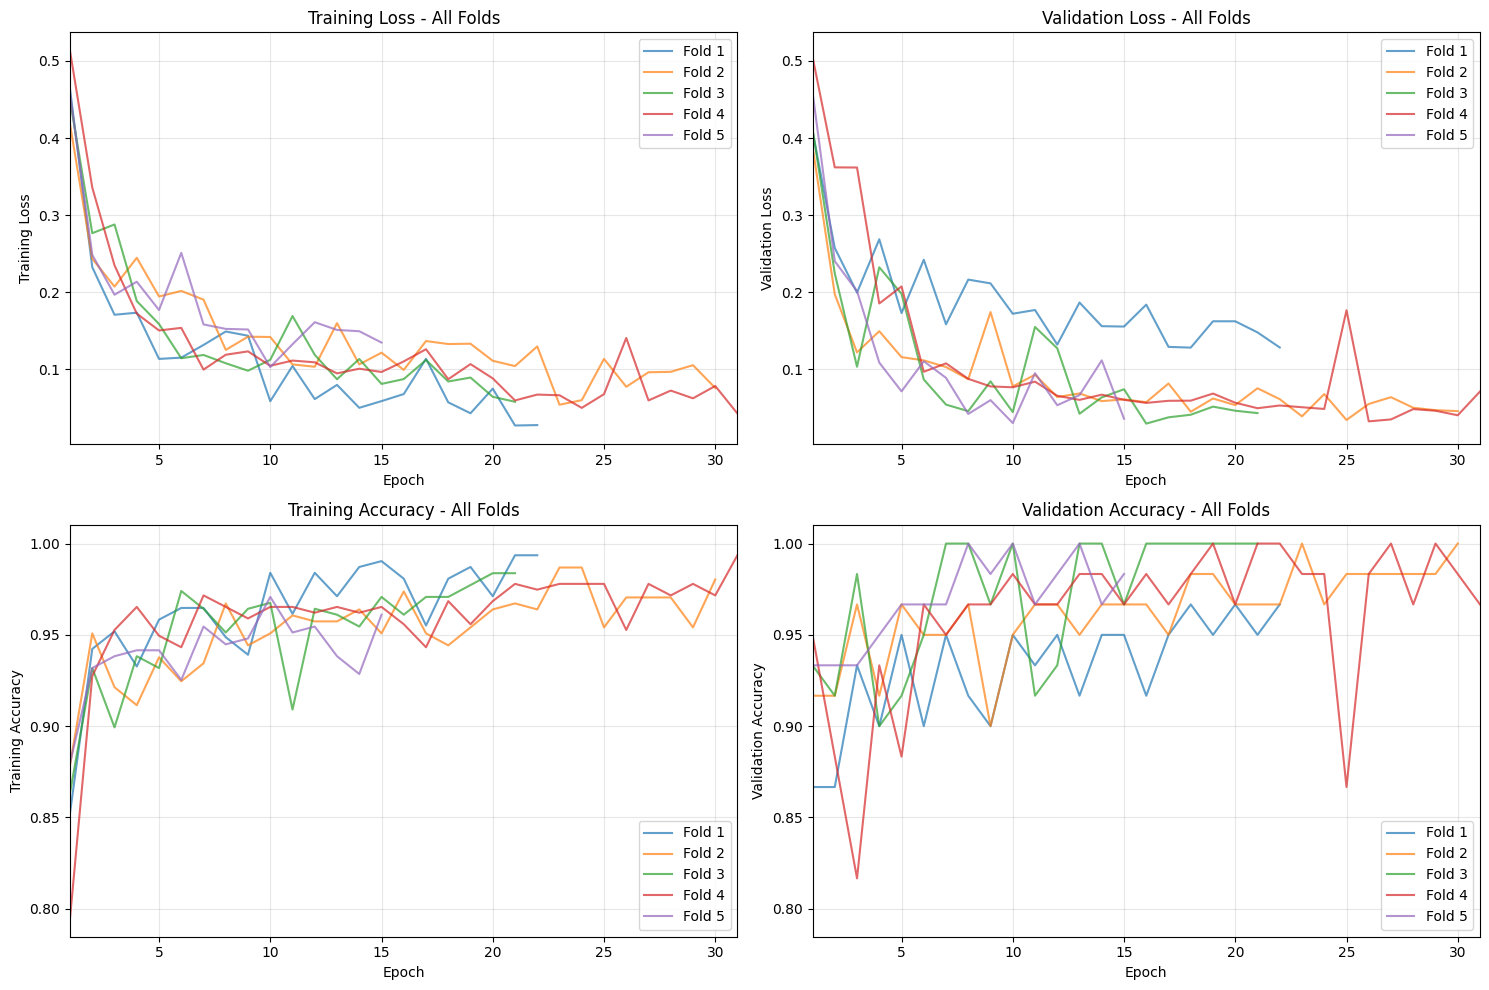

Mean accuracy: 0.9833
Std accuracy: 0.0183
Best fold: 3
Best accuracy: 1.0000


In [24]:
plot_kfold_results(cv_results_with_aug , 5)

print(f"Mean accuracy: {np.mean(cv_results_with_aug ['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(cv_results_with_aug ['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(cv_results_with_aug ['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {cv_results_with_aug ['best_val_accs'][best_fold_idx]:.4f}")

### Final Model Summary
- Much better senstivity (~97%): provides key evidence for epilepsy diagnosis
- Overall good accuracy and balance between sensitivity and specifity
- Model performance was more consistent over 5 folds
- Still a bit of variability in validation accuracy/loss across epochs, although this could just be due to smaller sample size resulting in larger jumps
- Could see if splitting 23 second segments into shorter sub-segments improves training. This would increase number of training samples which may help CNN learn better but may lose temporal context in longer seizures

## Limitations and Future Directions

1. **Lack of patient-level metadata**

The BONN dataset does not include patient identifiers, so the same individual may appear in both the training and validation splits. This can inflate performance estimates and limits the ability to assess true generalisation to unseen patients.

2. **Need for external validation**

To properly evaluate real-world generalisability, the model should be tested on an independent dataset containing different subjects and recording conditions. This would demonstrate whether the learned features transfer beyond the BONN data.
However, incorporating an external dataset introduces additional considerations:
Preprocessing differences (e.g., filtering, artefact removal)
Channel selection or averaging to match configurations
Resampling to align sampling frequencies
Potential differences in hardware, noise profiles, and clinical conditions


3. **Potential improvement via transfer learning**

A practical next step is to pretrain the CNN on the BONN dataset, freeze early convolutional layers, and fine-tune on a second dataset. This approach reduces training time, leverages learned low-level EEG features, and provides a more realistic estimate of how the model might perform in cross-dataset or clinical deployment scenarios.